In [1]:
from pytorch_lightning.loggers import TensorBoardLogger #implemented using SumaryWriter
#from task import DMTSDataModule #spatial version, distraction code removed
from spatial_task import DMTSDataModule #spatial version, distraction code removed
from networks import DMTSNet
import torch
from main_as_script import import_model_task_trainer
import matplotlib.pyplot as plt
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE" #fix for weird issue where matplotlib kills  kernel

In [2]:
#set up logger with log folder and model name
logger = TensorBoardLogger('tb_logs', name='uniform')

1 GPU availible
The batch size is set to 32


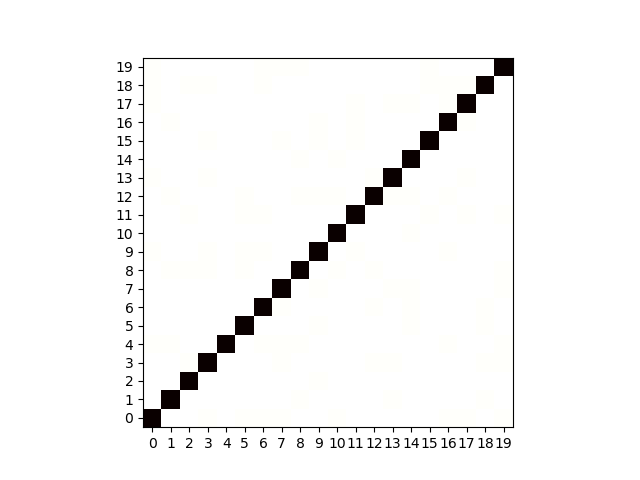

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [16]:
# rnn options: fixed, stsp, depressing, vanilla
# init options: log, uniform, He, normal
model,task,trainer = import_model_task_trainer(
    logger, 
    label = 'UniPlas3',
    
    rnn_type = 'stsp', 
    nonlinearity = 'relu', 
    hidden_size = 20, 
    learning_rate = .02, 
    gamma = .005, 
    act_reg = 1e-3, 
    param_reg = 1e-4, 
    init_method = 'uniform',
    
    noise_level = 0.01,
    difficulty_level = 2,
    
    epochs = 10, 
    optimizer = "Adam",
    BATCH_SIZE = 32
)

In [ ]:
#alt: reload and retrain old model
ckpt = "HePlas_stsp_relu_20_0.005_0.02_0.001_0.0001_He_0.01_1_Adam_32epoch=02--val_acc=0.50.ckpt"
ckpt_dir = r"D:\CL-nets\02_07_23\_lightning_sandbox\checkpoints"
model = DMTSNet.load_from_checkpoint(os.path.join(ckpt_dir, ckpt))

In [4]:
%load_ext tensorboard

In [5]:
%tensorboard --logdir=tb_logs/ --port 8800 #--host localhost

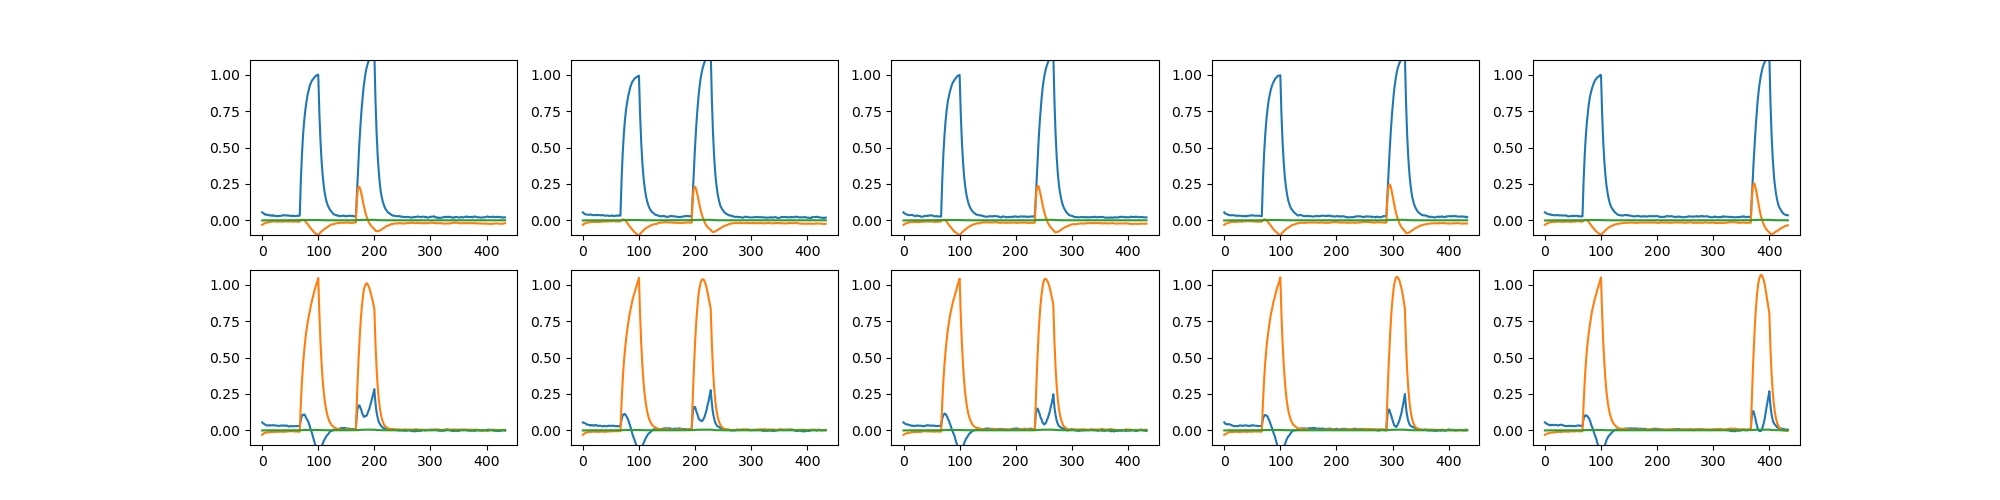

In [17]:
trainer.fit(model, task)

suggested changes from [forum](https://github.com/keras-team/keras/issues/6447):
- smaller batch size (Adam takes big steps early on, small steps later; batch size will especially affect initial steps)
- change initialization (final weights aren't that different from intial; stronger initial connections injects more chaos)
- smaller learning rate (or larger learning rate and swtich to SGD)
- smaller hidden layer: _"Generally, the more complex the network, the more weights to the network has to tune, so many of them become dead in the process, hence same output"_

### load old model

In [18]:
ls -t _lightning_sandbox\checkpoints

 Volume in drive D is DATA
 Volume Serial Number is 8EFE-CC3E

 Directory of D:\CL-nets\02_07_23


 Directory of D:\CL-nets\02_07_23\_lightning_sandbox\checkpoints

02/16/2023  10:33 AM    <DIR>          .
02/16/2023  10:33 AM    <DIR>          ..
02/07/2023  11:34 AM            20,430 _stsp_relu_20_0.005_0.02_0.001_0.0001_log_0.01_1_Adam_32epoch=09--val_acc=0.51.ckpt
02/07/2023  05:01 PM            20,302 HeDep1_depressing_relu_20_0.005_0.02_0.001_0.0001_He_0.01_2_Adam_32epoch=01--val_acc=0.94.ckpt
02/07/2023  05:07 PM            20,302 HeDep2_depressing_relu_20_0.005_0.02_0.001_0.0001_He_0.01_2_Adam_32epoch=01--val_acc=0.94.ckpt
02/07/2023  05:14 PM            20,302 HeDep3_depressing_relu_20_0.005_0.02_0.001_0.0001_He_0.01_2_Adam_32epoch=02--val_acc=0.92.ckpt
02/07/2023  03:36 PM            20,302 HePlas_stsp_relu_20_0.005_0.02_0.001_0.0001_He_0.01_1_Adam_32epoch=02--val_acc=0.50.ckpt
02/07/2023  04:03 PM            20,302 HePlas_stsp_relu_20_0.005_0.02_0.001_0.0001_He_0.01_2_Adam_3

File Not Found


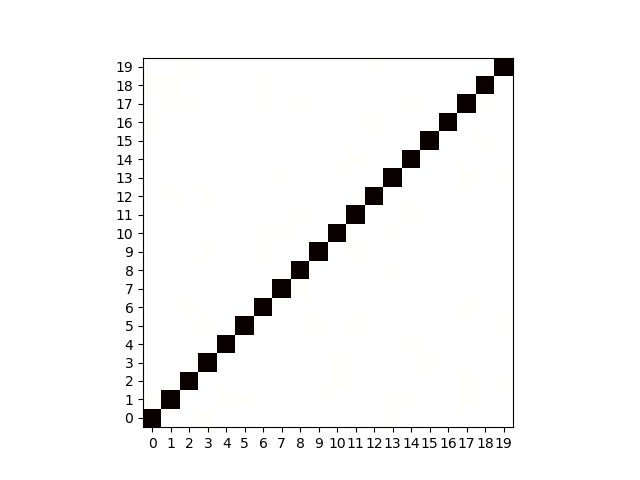

In [19]:
ckpt = "UniPlas3-stsp-relu-20-0.005-0.02-0.001-0.0001-uniform-0.01-2-Adam-32-epoch=02-val_acc=0.96" + ".ckpt"
#ckpt = os.listdir("_lightning_sandbox/checkpoints")[-3]
ckpt_dir = r"D:\CL-nets\02_07_23\_lightning_sandbox\checkpoints"
model = DMTSNet.load_from_checkpoint(os.path.join(ckpt_dir, ckpt))
task = DMTSDataModule(dt_ann=15, noise_level=0.01) 

### check output

In [20]:
#load task 
task.setup()
tester = task.test_dataloader()
inp, out_des,y,test_on = next(iter(tester))

#get model output
out_readout, out_hidden, w_hidden, _ = model(inp)

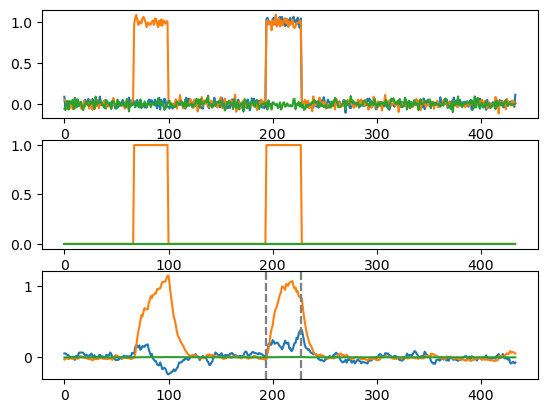

In [21]:
#check inputs, desired outputs, and actual outputs for one trial at a time
trial = 3
f,ax = plt.subplots(3,1)
with torch.no_grad():
    for node in range(3): #2 samples + 1 fixation
        ax[0].plot(inp[trial,:,node])
        ax[1].plot(out_des[trial,:,node])
        ax[2].plot(out_readout[trial][:][:,node])
        ax[2].axvline(test_on[trial], linestyle='--', color='gray') #lines around area that loss is calculated on
        ax[2].axvline(test_on[trial]+500/15, linestyle='--', color='gray')

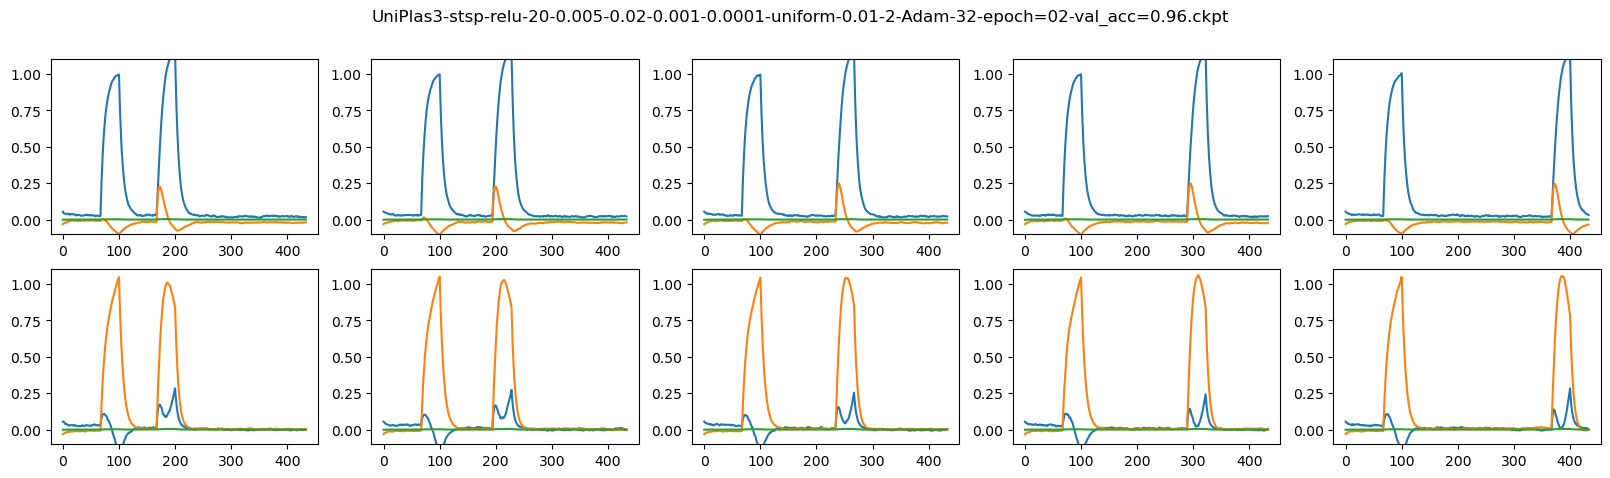

In [22]:
#view output for each sample-delay combo, averaged across all trials
f,ax=plt.subplots(2,5, figsize=(20,5))
with torch.no_grad():
    
    for sample in range(2): #2 sample inputs
        for i,delay in enumerate(torch.unique(test_on)): #for each delay
            inds = torch.where((y == sample) & (test_on == delay))[0]
            ax[sample,i].set_ylim(-.1,1.1)
            ax[sample,i].plot(out_readout[inds].mean(0))
            
f.suptitle(ckpt);

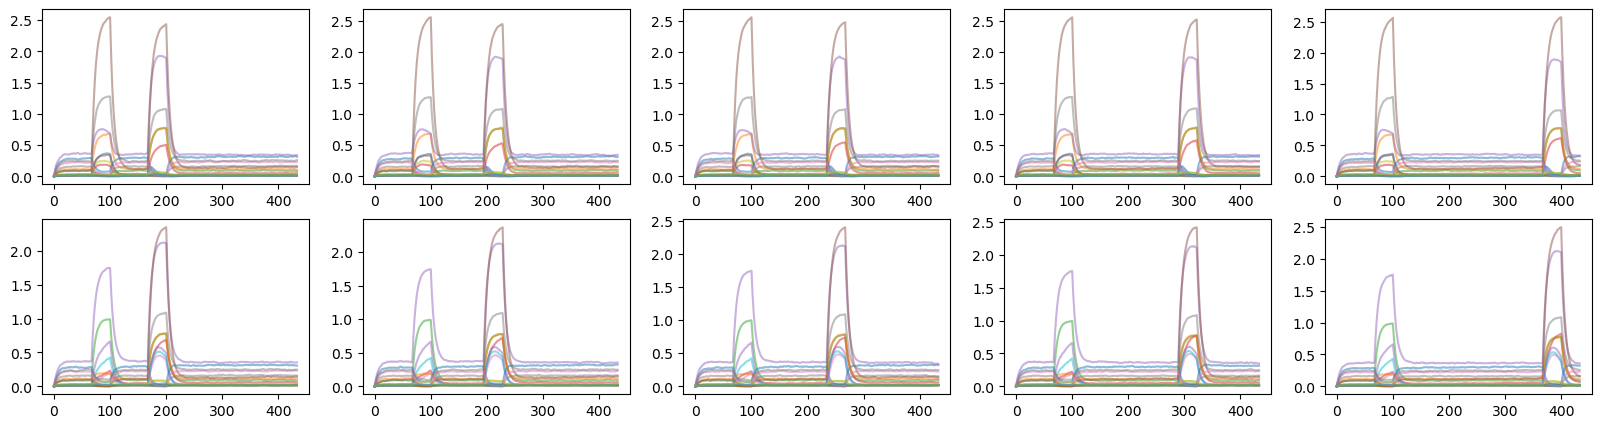

In [23]:
#view mean hidden-layer activity for each sample-delay combo, averaged across all trials
f,ax=plt.subplots(2,5, figsize=(20,5))
with torch.no_grad():
    
    for sample in range(2):
        for i,delay in enumerate(torch.unique(test_on)): #for each delay
            inds = torch.where((y == sample) & (test_on == delay))[0]
            ax[sample,i].plot(out_hidden[inds].mean(0), alpha=0.5)

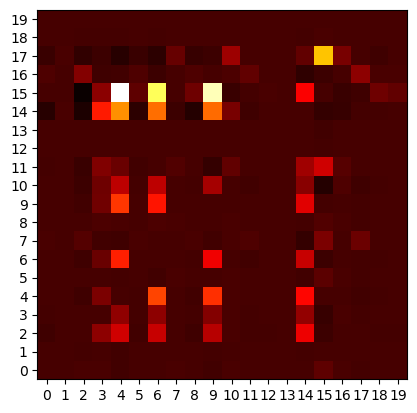

In [24]:
plt.imshow(model.rnn.W.detach().numpy(), origin='lower', cmap='hot')
ticks = range(0,20)
plt.xticks(ticks);
plt.yticks(ticks);

In [15]:
model.rnn.W

Parameter containing:
tensor([[ 0.0000e+00, -1.6663e-05, -8.6076e-03,  5.6475e-03,  1.2479e-01,
         -1.5673e-03,  4.8182e-02,  6.8553e-01, -1.2168e-02, -9.8219e-02,
          2.3262e-03, -2.3000e-02,  7.6711e-01, -1.8610e-03, -8.8665e-02,
         -7.5022e-05,  3.7599e-03,  6.1665e-01, -1.1576e-01,  4.5686e-03],
        [-2.2209e-04,  0.0000e+00,  1.3080e-03, -1.2247e-04,  9.4473e-03,
         -1.2327e-04,  1.4301e-03, -3.1530e-04,  1.9723e-04,  1.8647e-04,
         -5.9375e-05, -4.7148e-03,  1.4239e-02,  1.0716e-03, -7.5454e-03,
          1.8780e-04, -1.0488e-07, -7.5172e-04, -2.5002e-03,  4.5771e-05],
        [-2.0913e-04, -1.1712e-04,  0.0000e+00,  8.9833e-03, -9.4467e-03,
         -4.6122e-03,  7.7329e-02,  6.2005e-01, -9.1127e-03, -7.3440e-02,
          4.0914e-03, -8.1097e-03,  6.0048e-01, -9.1315e-03, -2.2423e-03,
         -2.4131e-04,  7.6404e-03, -1.2694e-03, -1.2236e-01,  9.1142e-03],
        [-1.2688e-03,  5.2648e-05, -2.1152e-03,  0.0000e+00,  1.9535e-02,
         -1.0